In [21]:
import os
import torch
from torch import nn
import random
from PIL import Image
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset,DataLoader
from torchvision.transforms import v2

In [22]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
current_path = os.getcwd()
print(current_path)

C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB


In [4]:
train_dir = os.path.join(current_path, 'images\\training')
test_dir = os.path.join(current_path, 'images\\testing')
train_dir, test_dir

('C:\\Users\\PicardiC\\apziva_projects\\-k9yztuWskyqtcZpB\\images\\training',
 'C:\\Users\\PicardiC\\apziva_projects\\-k9yztuWskyqtcZpB\\images\\testing')

### Understanding the data

Random image path: images\training\notflip\0044_000000007.jpg
Image class: notflip
Image height: 1920
Image width: 1080


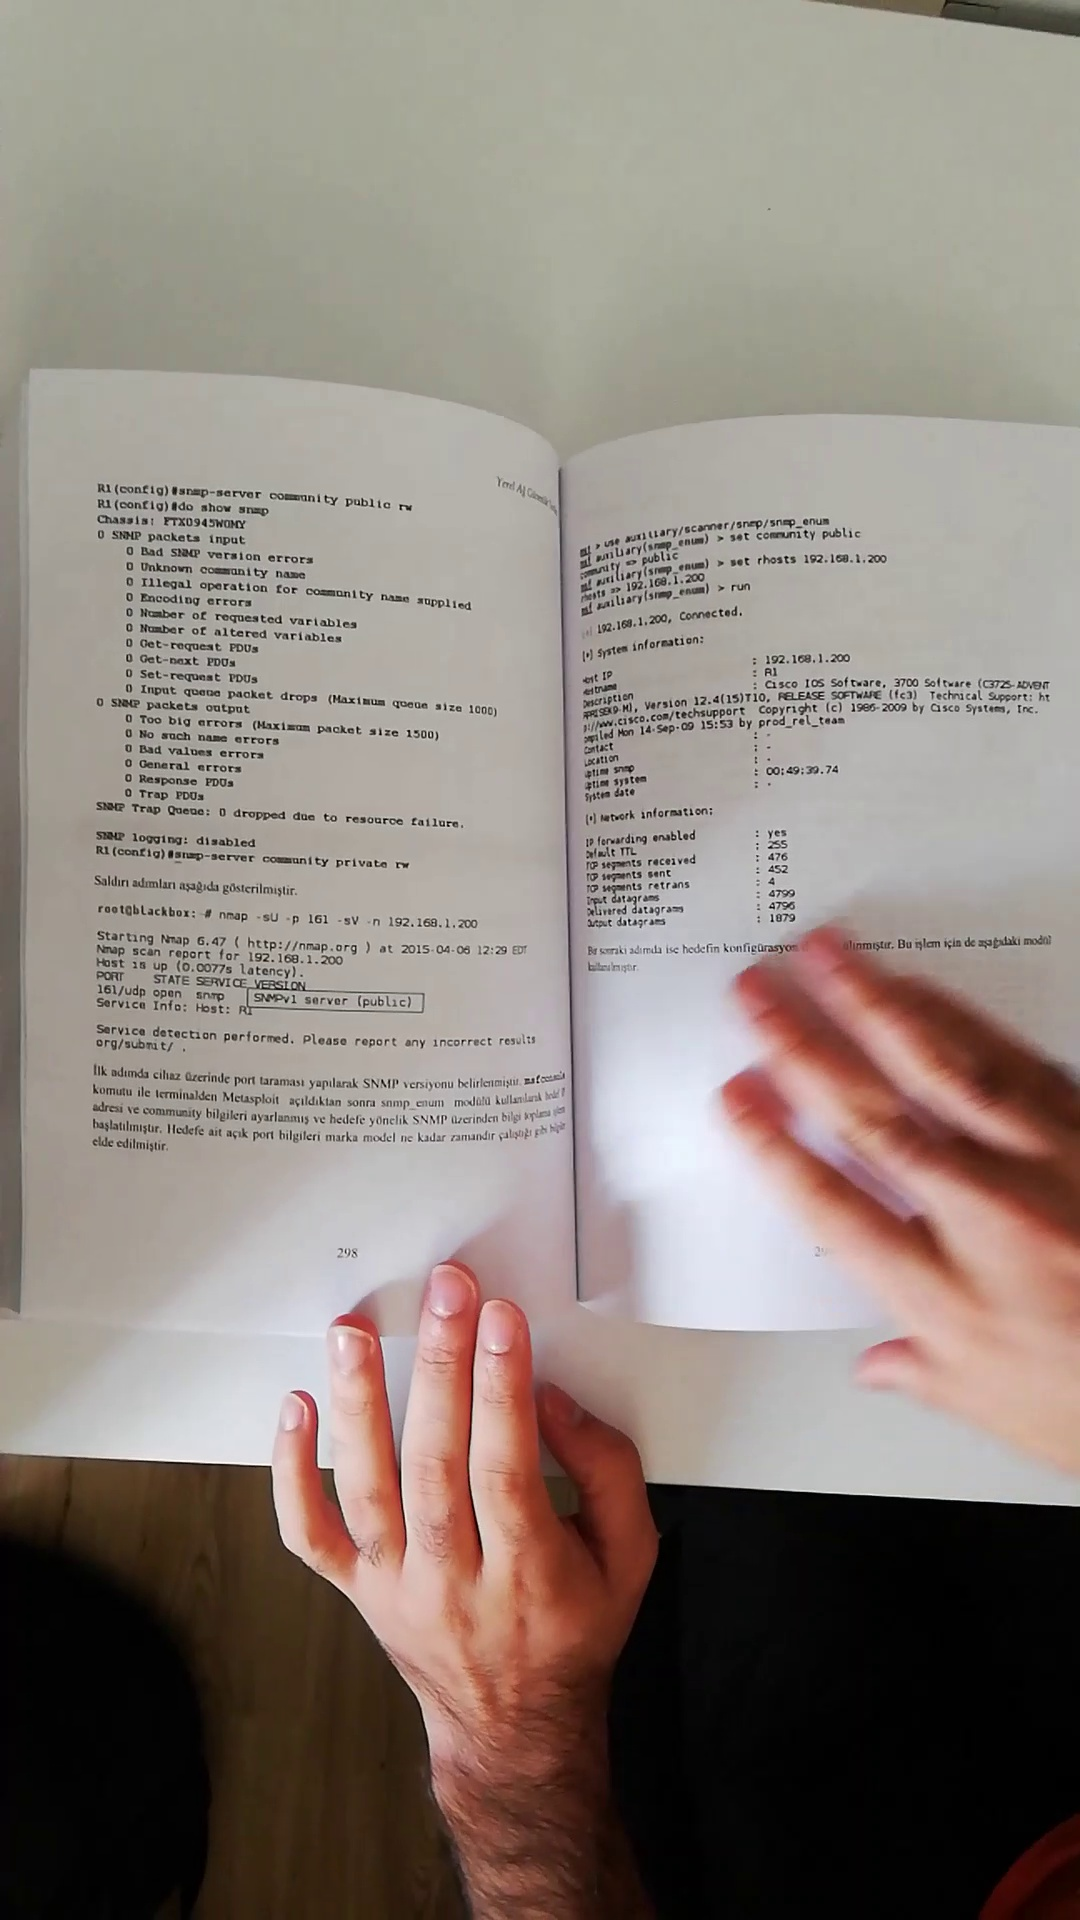

In [5]:
# Set seed
random.seed(42) 

image_path = 'images'

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

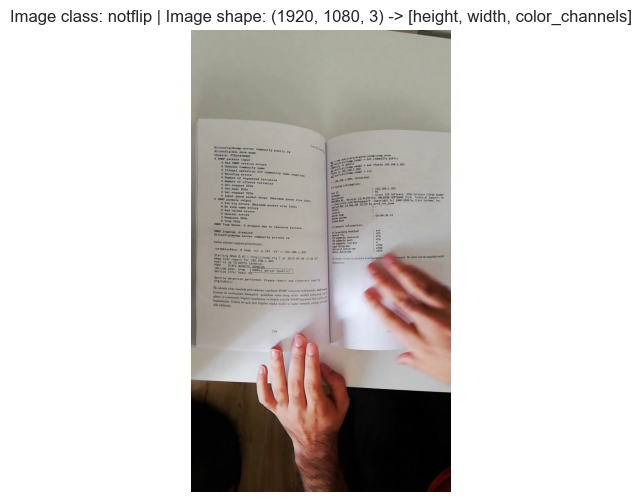

In [6]:
sns.set_theme()

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Image preprocessing

In [14]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

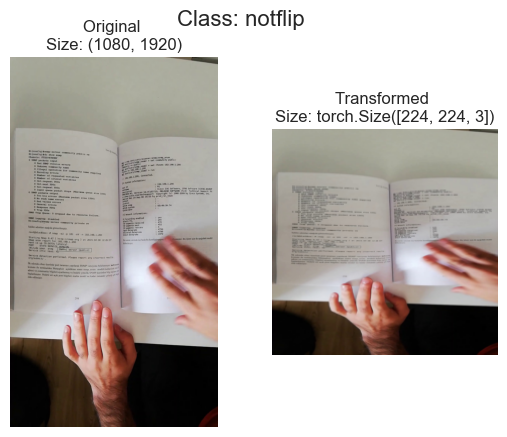

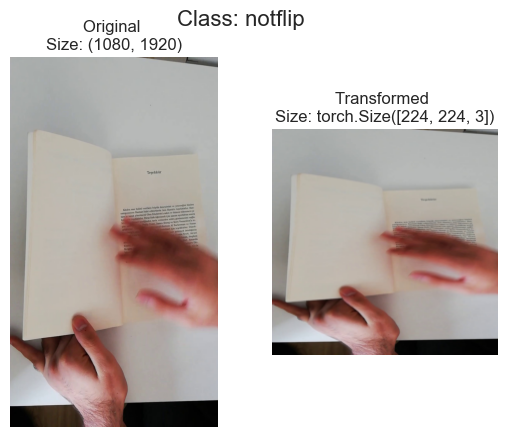

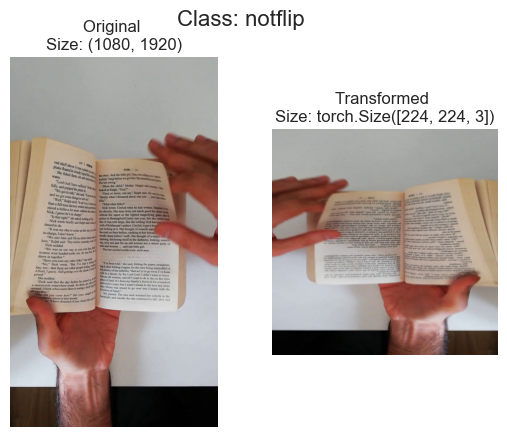

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

### Loading image data

In [16]:
from torchvision import datasets

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2392
    Root location: C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB\images\training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 597
    Root location: C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB\images\testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [17]:
# Get class names as a list
class_names = train_data.classes
print("Class names: ",class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))


Class names:  ['flip', 'notflip']
Class names as a dict:  {'flip': 0, 'notflip': 1}
The lengths of the training and test sets:  2392 597


Create DataLoader for training

In [18]:
# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=30, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2761d753b10>,
 <torch.utils.data.dataloader.DataLoader at 0x27619d5b3d0>)

### Augmenting training set

In [23]:
# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])


In [29]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)
train_data = ConcatDataset([train_data, train_data_augmented])
for l in train_data.datasets:
    print(l)
print(test_data)

Dataset ImageFolder
    Number of datapoints: 2392
    Root location: C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB\images\training
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 597
    Root location: C:\Users\PicardiC\apziva_projects\-k9yztuWskyqtcZpB\images\testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [25]:
# Get class names as a list
class_names = train_data.classes
print("Class names: ",class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))


AttributeError: 'ConcatDataset' object has no attribute 'classes'